In [4]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from jax import Array
from dsolve.sequence_space.sequence_space import SequenceSpaceModel, solve_impulse_response

## AR1

$$x_t = \rho x_{t-1}+\epsilon_t$$

In [5]:
rho = 0.9

def ar1(x_: Array, x:Array, x1:Array, eps_:Array, eps:Array, eps1:Array)->Array:
    out = jnp.zeros(1)
    out = out.at[0].set(rho*x_[0]+eps[0]-x[0])
    return out

In [6]:
T = 100
ss0 = jnp.array([0])
ar1_model = SequenceSpaceModel(ar1, T= T, ss0 = ss0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [10]:
Eps = jnp.zeros((T+1,1))
Eps = Eps.at[0].set(1)
X = solve_impulse_response(ar1_model, Eps)

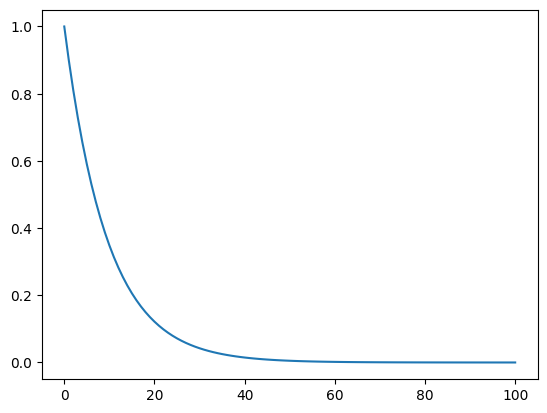

In [11]:
plt.plot(X)

In [29]:
ss0 = jnp.array([0.])
n_x = 1
X_guess = jnp.tile(F.ss0,(F.T+1,1))*1.0

jac = jax.jacfwd(lambda x: F(x.reshape(-1,n_x),Eps).flatten())(X_guess.flatten())

X_new = X_guess.flatten()-0.01*jax.scipy.linalg.inv(jac)@F(X_guess,Eps).flatten()
X_new = X_new.reshape(-1,n_x)

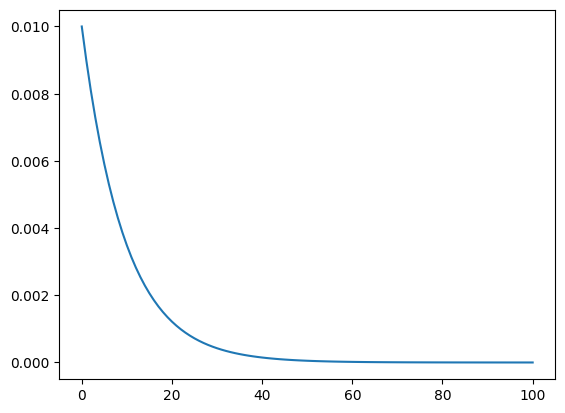

In [30]:
plt.plot(X_new)

## VAR

$x_t=Ax_{t-1}+B\epsilon_t$



$X_t=\begin{bmatrix}x_0\\x_1\\ \vdots \\x_T\end{bmatrix}$

In [16]:
A = jnp.array([[0.8,0.2],
                [0.1,0.7]])
B = jnp.array([[1],
               [0.5]])
def var(x_, x, x1, eps_, eps, eps1):
    '''
    x: 1d array
    eps: 1d array
    Returns
    -------
    1d array
    '''
    return A@x_+B@eps-x

In [17]:
T = 100
ss0 = jnp.array([0,0])
var_model = SequenceSpaceModel(var, T= T, ss0 = ss0)

In [18]:
Eps = jnp.zeros((T+1,1))
Eps = Eps.at[0].set(1)
Eps = Eps.at[10].set(1)
X = solve_impulse_response(var_model, Eps)

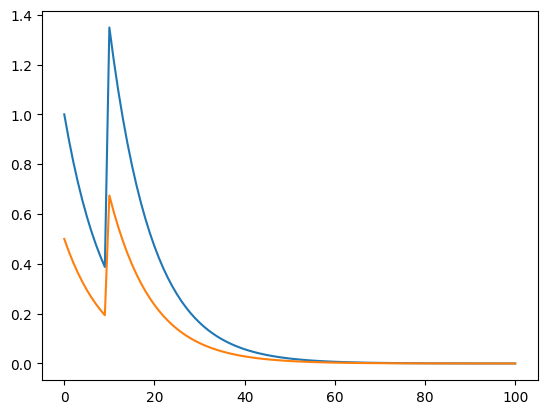

In [19]:
plt.plot(X)

## NK model

$$\pi_t=\beta E[\pi_{t+1}]+\kappa y_{t}$$
$$y_t=E[y_{t+1}]+(1-\phi)E[\pi_{t+1}]+v_t$$
$$v_{t} = \rho_vv_{t-1}+\epsilon_{t}$$

In [12]:
phi = 1.2
kappa = 0.1
beta = 0.99
rho_v = 0.5

def nk_equations(x_:Array, x:Array, x1:Array, eps:Array)->Array:
    '''
    Returns the error of the function f(x_{t-1},x_{t},x_{t+1}, eps_{t})=0
    x: [y,pi,v]
    '''
    v_ = x_[2]
    y, pi, v = x
    y1, pi1 = x1[jnp.array([0,1])]
    out = jnp.zeros(3)
    out = out.at[0].set(beta*pi1+kappa*y-pi)
    out = out.at[1].set(y1+(1-phi)*pi1+v-y)
    out = out.at[2].set(rho_v*v_+eps[0]-v)
    return out

In [13]:
T = 50
ss0 = jnp.array([0,0,0])
F = build_F(f = nk_equations, T = T, ss0 = ss0)

In [14]:
Eps = jnp.zeros((T+1,1))
Eps = Eps.at[0].set(1)

In [15]:
X = solve_model(F, Eps)

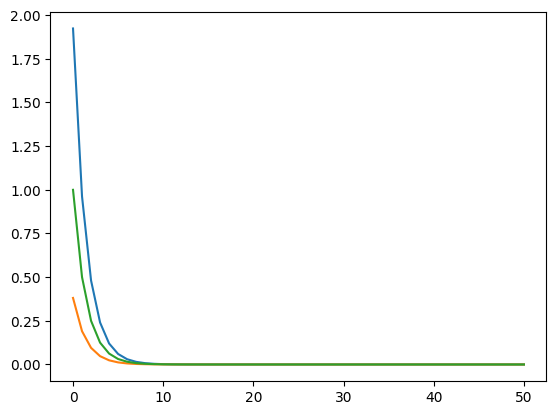

In [16]:
plt.plot(X)